In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from scipy import stats
from scipy.spatial.distance import pdist
from geopy.distance import vincenty

In [398]:
vt_df = pd.read_csv(r'D:\DataIncubator\Questions\Cohort_Spring\VT_cleaned.csv', low_memory=False)
mt_df = pd.read_csv(r'D:\DataIncubator\Questions\Cohort_Spring\MT_cleaned.csv', low_memory=False)

Fraction of Male driver =  0.6749749733
arrest probability ration =  1.2095129351
Chi_squared =  128.729163242


                     |  out_of_state  |   in_state
         ============|================|===============
         not_arested:|       198773   |     604588
         ------------|----------------|--------------
             arested:|       4868     |     12190
         ============|================|===============
               Total:|       203641   |     616778


speeding_proprotion =  0.6580998112
How much more likely DUI Montana - Vermont =  0.008159323


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:68: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


prediction for year 2020 :  [[ 2008.84316596]]


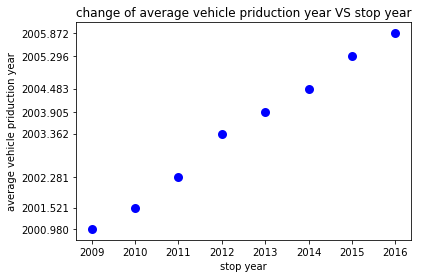

p_value is : 5.60914825372e-08


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Difference between most stops and least stops : 95344
Area of the bigest county is :  2201.66884535


In [479]:
# Fraction of Male driver in Mantana:
# Question Q2-part a
res_a = np.round(len(mt_df[mt_df.driver_gender == 'M'])/ len(mt_df), 10)
print('Fraction of Male driver = ', res_a)

# out-of-state arrests in Montana:
mt_data_cleaned = mt_df[(~mt_df['out_of_state'].isnull()) & ~mt_df['is_arrested'].isnull()][['is_arrested', 'out_of_state']]
out_of_state = mt_data_cleaned[mt_data_cleaned.out_of_state == True]
in_state = mt_data_cleaned[mt_data_cleaned.out_of_state == False]
count_out_of_state = len(out_of_state)
count_out_of_state_arrested  = len(out_of_state[out_of_state.is_arrested])
count_in_state = len(in_state)
count_in_state_arrest = len(in_state[in_state.is_arrested])

#Question Q2-part b
p_arrest_out_of_state  = count_out_of_state_arrested/count_out_of_state
p_arrest_in_state  = count_in_state_arrest/count_in_state
res_b = np.round(p_arrest_out_of_state/p_arrest_in_state, 10)
print('arrest probability ration = ', res_b) 

#Question Q2-part c
from scipy.stats import chi2_contingency
obs = np.array([[4868, 198773], [12190, 604588]])
chi2, p, dof, expecte = chi2_contingency(obs)
print('Chi_squared = ',chi2)

#printing out stats:
print('\n')
print('                     |  out_of_state ' , '|' , '  in_state')
print('         ============|================|===============')
print('         not_arested:|',' '*5, count_out_of_state - count_out_of_state_arrested,' '*1,'|',' '*3, count_in_state - count_in_state_arrest)
print('         ------------|----------------|--------------')
print('             arested:|',' '*5, count_out_of_state_arrested,' '*3,'|',' '*3, count_in_state_arrest)
print('         ============|================|===============')
print('               Total:|',' '*5, count_out_of_state,' '*1,'|',' '*3, count_in_state)

# to be used several times
def calcViolationProportion(df, violationType):
    violations = df['violation'].astype(str)
    viol_list = [i.split(',') for i in violations]
    count_viol  = len(viol_list)
    viol_of_interest = [i for i in viol_list if str(violationType) in i]
    count_viol_of_interest = len(viol_of_interest)
    return count_viol_of_interest/ count_viol

#Question Q2-part d
#speeding_proprotion
print('\n')
print('speeding_proprotion = ', np.round(calcViolationProportion(mt_df, 'Speeding'), 10)) #0.6580998112

#Question Q2-part e
#How much more likely does a traffic stop in Montana result in a DUI
dui_proprotion_montana = calcViolationProportion(mt_df, 'DUI')
dui_proprotion_vermont = calcViolationProportion(vt_df, 'DUI')
print('How much more likely DUI Montana - Vermont = ' , np.round(dui_proprotion_montana - dui_proprotion_vermont, 9))


#Question Q2-part f
vehicle_Stop_year = mt_df[(~mt_df.stop_date.isnull()) & (~mt_df.vehicle_year.isnull())][[ 'stop_date',  'vehicle_year']]
vehicle_Stop_year = vehicle_Stop_year[[vy.isdigit() for vy in vehicle_Stop_year.vehicle_year.astype(str)]] 
vehicle_Stop_year['stop_year'] = [s[:4] for s in vehicle_Stop_year['stop_date']]
vehicle_Stop_year = vehicle_Stop_year[['vehicle_year','stop_year']].apply(pd.to_numeric)
dat =pd.DataFrame({'mean_vehicle_year' : vehicle_Stop_year.groupby(['stop_year'])['vehicle_year'].mean()}).reset_index()


# Split the targets into training/testing sets
dat_x_train = dat.stop_year.reshape(-1, 1)
dat_y_train = dat.mean_vehicle_year.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(dat_x_train, dat_y_train)
print('prediction for year 2020 : ', regr.predict(2020))

# Plot outputs
plt.scatter(dat_x_train, dat_y_train,  color='blue', linewidth=3)
plt.xticks(dat_x_train)
plt.yticks(dat_y_train)
plt.title('change of average vehicle priduction year VS stop year')
plt.xlabel('stop year')
plt.ylabel('average vehicle priduction year')
plt.show()


#Question Q2-part g:
dat_x_train_est = sm.add_constant(dat_x_train)
est = sm.OLS(dat_y_train, dat_x_train_est)
print('p_value is :',  est.fit().f_pvalue) 


#Question Q2-part h:
mt_df_cleaned = mt_df[~mt_df.stop_time.isnull()]
vt_df['stop_hour'] = vt_df['stop_time' ].apply(lambda x : int(x.strip()[:2]))
mt_df_cleaned['stop_hour'] = mt_df_cleaned['stop_time' ].apply(lambda x : int(x.strip()[:2]))
stop_hours_df = pd.concat([vt_df[['stop_time', 'stop_hour']], mt_df_cleaned[['stop_time', 'stop_hour']]])
hour_group = pd.DataFrame({'stop_per_hour':stop_hours_df.groupby(stop_hours_df.stop_hour)['stop_time'].count()})
stop_hour_max = hour_group['stop_per_hour'].max()
stop_hour_min = hour_group['stop_per_hour'].min()
print('Difference between most stops and least stops :', stop_hour_max - stop_hour_min)


#Question Q2-part i:
# cleaning data
# Montana Longitude: -104° 2'  to -116° 2'  and Latitude: 44° 26'N to 49°N
df = mt_df[['county_fips', 'lat', 'lon']].apply(pd.to_numeric)
df = df[ (~df.lat.isnull()) & (~df.lon.isnull()) & (df.lat > 44) & (df.lat < 50) & (df.lon < -104) & (df.lon > -116.2)]

#grouping by county_fips:
latgroup = df.groupby(['county_fips'])['lat']
longroup = df.groupby(['county_fips'])['lon']
montana_geo_stat = pd.DataFrame({'lat_std': latgroup.std(), 'lat_mean': latgroup.mean(), 
                                'lon_std': longroup.std(), 'lon_mean': longroup.mean()})


def calcGeoArea(lat_mean, lon_mean, lat_std, lon_std):
    lat_coordinates = np.array([[lat_mean - lat_std, lon_mean], [lat_mean, lon_mean] ])
    a = pdist(lat_coordinates,  lambda u, v: vincenty(u, v).kilometers)
    
    lon_coordinates = np.array([[lat_mean , lon_mean -lon_std], [lat_mean, lon_mean] ])
    b = pdist(lon_coordinates,  lambda u, v: vincenty(u, v).kilometers)
    return (np.pi * a * b)[0]

def calGeoArea_df(dat_df):
    return dat_df.apply(lambda row: calcGeoArea(lat_mean= row['lat_mean'], lat_std= row['lat_std'], 
                                         lon_mean= row['lon_mean'], lon_std= row['lon_std']), axis=1)

montana_geo_stat['area'] = calGeoArea_df(montana_geo_stat)
print('Area of the bigest county is : ', np.round(montana_geo_stat['area'].max(), 9))

